## Definitions

In [0]:
%matplotlib inline
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV

from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adadelta, Adam, SGD, Nadam
from keras.layers import Input, Conv2D, Dense, MaxPooling2D, Dropout, Flatten, AveragePooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Sequential
from keras.losses import categorical_crossentropy
from keras.wrappers.scikit_learn import KerasClassifier

from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
os.chdir("/content/gdrive/My Drive/Colab Notebooks") # might have to change path to point to your Colab Notebooks folder

import warnings
warnings.filterwarnings("ignore")

## Load and format data

Number of classes: 10
Example of handwritten digit with correlated noise: 



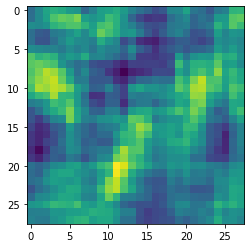

Class: 1

Shape of x_train: (60000, 28, 28, 1)
Shape of y_train: (60000, 10)


In [2]:
data = np.load('./MNIST_CorrNoise.npz')

x_train = data['x_train']
y_train = data['y_train']

num_cls = len(np.unique(y_train))
print('Number of classes: ' + str(num_cls))

print('Example of handwritten digit with correlated noise: \n')

k = 67
plt.imshow(np.squeeze(x_train[k,:,:]))
plt.show()
print('Class: '+str(y_train[k])+'\n')

# RESHAPE and normalize
x_train = np.expand_dims(x_train/255,axis=3)

# convert class vectors to binary class matrices
y_train = to_categorical(y_train, num_cls)

print('Shape of x_train: '+str(x_train.shape))
print('Shape of y_train: '+str(y_train.shape))

## Training

In [0]:

model_name='CNN' # To compare models, you can give them different names

pweight='./weights/weights_' + model_name  + '.hdf5'

if not os.path.exists('./weights'):
  os.mkdir('./weights')

## EXPLORE VALUES AND FIND A GOOD SET
b_size = 100 # batch size
val_split = 0.1 # percentage of samples used for validation (e.g. 0.5)
ep = 100 # number of epochs


x_train=np.pad(x_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')  # Zero padding 



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 54000 samples, validate on 6000 samples
Epoch 1/100





54000/54000 [==============================] - 10s 190us/step - loss: 1.2610 - acc: 0.5667 - val_loss: 0.7028 - val_acc: 0.7687

Epoch 00001: val_loss improved from inf to 0.70284, saving model to ./weights/weights_CNN.hdf5
Epoch 2/100
54000/54000 [==============================] - 3s 57us/step - loss: 0.7009 - acc: 0.7642 - val_loss: 0.5639 - val_acc: 0.8117

Epoch 00002: val_loss improved from 0.70284 to 0.56390, saving model to ./weights/weights_CNN.hdf5
Epoch 3/100
54000/54000 [==============================] - 3s 58us/step - loss: 0.5718 - acc: 0.8068 - val_loss: 0.5217 - val_acc: 0.8218

Epoch 00003: val_loss improved from 0.56390 to 0.52173, saving model to ./weights/weights_CNN.hdf5
Epoch 4/100
54000/54000 [==============================] - 3s 57us/step - loss: 0.4940 - acc: 0.8334 - val_loss: 0.4354 - val_acc: 0.85

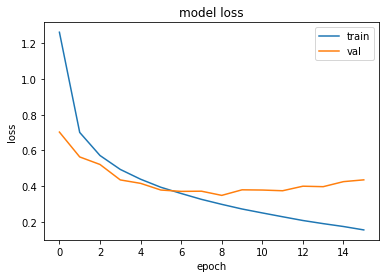

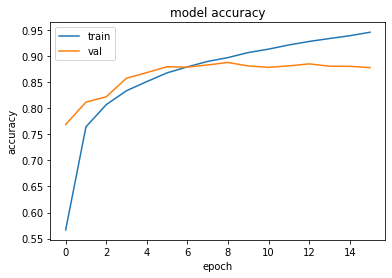

In [6]:

#input_shape = x_train.shape[1:4] #(32,32,1)
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(32,32,1)))
    model.add(AveragePooling2D())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    model.add(AveragePooling2D())
    model.add(Flatten())
    model.add(Dense(units=120, activation='relu'))
    model.add(Dense(units=84, activation='relu'))
    model.add(Dense(units=10, activation = 'softmax'))
    model.compile(loss=categorical_crossentropy,
              optimizer=Nadam(), # explore other optimizers: Adam, SGD
              metrics=['accuracy'])
    return model
model = KerasClassifier(build_fn=create_model, verbose=-1)


"""
# define the grid search parameters
batch_size = [200,500,1000]
epochs = [10,20]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3,verbose=0)
checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)
callbacks_list = [checkpointer] # explore adding other callbacks such as ReduceLROnPlateau, EarlyStopping

#from sklearn.externals.joblib import parallel_backend

#with parallel_backend('threading'):
grid_result =grid.fit(x_train, y_train)


print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

"""
checkpointer = ModelCheckpoint(filepath=pweight, verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
callbacks_list = [checkpointer, earlystop] # explore adding other callbacks such as ReduceLROnPlateau, EarlyStopping

history=model.fit(x_train, y_train,
                        epochs=ep,
                        batch_size=b_size,
                        verbose=1,
                        shuffle=True,
                        validation_split = val_split,
                        callbacks=callbacks_list)

print('CNN weights saved in ' + pweight)

# Plot loss vs epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Plot accuracy vs epochs
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()




## Make predictions in test set

In [7]:
from keras.models import load_model

## LOAD DATA
data = np.load('./MNIST_CorrNoise.npz')

x_test = data['x_test']
y_test = data['y_test'] 

num_cls = len(np.unique(y_test))
print('Number of classes: ' + str(num_cls))

# RESHAPE and standarize
x_test = np.expand_dims(x_test/255,axis=3)
x_test=np.pad(x_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
print('Shape of x_train: '+str(x_test.shape)+'\n')

## Define model parameters
model_name='CNN' # To compare models, you can give them different names
pweight='./weights/weights_' + model_name  + '.hdf5'

model = load_model(pweight)
y_pred = model.predict_classes(x_test)

Acc_pred = sum(y_pred == y_test)/len(y_test)

print('Accuracy in test set is: '+str(Acc_pred))


Number of classes: 10
Shape of x_train: (10000, 32, 32, 1)

Accuracy in test set is: 0.8712


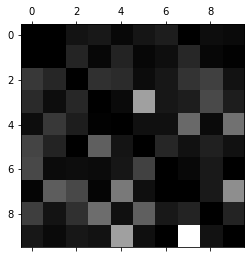

In [8]:

from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_test,y_pred)
row_sums = conf_mat.sum(axis=1, keepdims=True)
norm_conf_mat = conf_mat / row_sums
np.fill_diagonal(norm_conf_mat, 0)
plt.matshow(norm_conf_mat, cmap=plt.cm.gray)
plt.show()